# Airspeed Calibration

In [1]:
# Creating filepaths, data paths
name = '2022-06-15_CREATeV_AirspeedCalibration'
data_path = '../../data/'
data_folder = 'createv-2022-06-15'
file_name = 'june15_2022.BIN'
datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

In [2]:
# Getting packages #

from os import sys
import os
sys.path.append('../../')

%matplotlib widget

from matplotlib import pyplot as plt
from matplotlib.widgets import SpanSelector
import numpy as np
import pandas as pd
from scipy import optimize 
from scipy.io import savemat
from scipy import odr
import pandas as pd
import decimal
import math

import plotly.express as px

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

import data_exporter
import datetime

### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

# Setting Plot Defaults
plt.style.use('../../basic_plotter.mplstyle')

In [3]:
# Initializing mapbox parameters
token = "pk.eyJ1Ijoid2tlbXA5NCIsImEiOiJjbGI0NHJuemkwMmF2M29zM24xcTlpNXVjIn0.qSiAc29MftNSOK2DOpRggw"
color_scale = [(0, 'orange'), (1,'red')]

## Base Functions

In [4]:
# Function for span selection

def onselect_plotgroundtrack(xmin, xmax):
    xmin = decimal.Decimal(xmin)
    xmin = math.ceil(xmin)
    xmin = round(xmin)

    xmax = decimal.Decimal(xmax)
    xmax = math.floor(xmax)
    xmax = round(xmax)

    df_sample = df.iloc[xmin:xmax]

    fig2 = px.scatter_mapbox(df_sample, 
                        lat="Latitude", 
                        lon="Longitude", 
                        hover_name=df_sample.index, 
                        #hover_data=["Address", "Listed"],
                        color="Airspeed_Sensor0",
                        color_continuous_scale='jet',
                        #size="Listed",
                        zoom=15.5, 
                        height=600,
                        width=900,
                        labels={"Airspeed": 'Airspeed (m/s)'},
                        center={'lat':44.0427, 'lon':-79.845},
                        template='presentation')
    fig2.update_layout(mapbox_style="satellite", mapbox_accesstoken=token)
    fig2.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig2.show()

    # Try plotting time on the x axis, and overplotting index as the real axis.  
    # 1. Generate plot of airspeeds vs the absolute index
    # 2. Create a dummy series showing the time index

In [5]:
# Function for separating time indexed data by loiter number, and calculating loiter position

def loiter_show(df, loiter_times, segment_test, show=True):
    mask = cl_finders.mask_fromTime(df, loiter_times.index[segment_test], loiter_times.index[segment_test+1])
    segment = df[mask]

    lattitude = np.array(segment.Latitude)
    longitude = np.array(segment.Longitude)

    y0 = (np.max(lattitude) + np.min(lattitude)) * 0.5
    x0 = (np.max(longitude) + np.min(longitude)) * 0.5

    # Finding theta angles
    x_diffs = longitude - x0
    y_diffs = lattitude - y0

    thetas = np.arctan2(y_diffs, x_diffs) * 180 / np.pi

    thetas = np.where(thetas < 0, thetas + 360, thetas)

    jump = np.diff(thetas)
    jump = np.abs(np.insert(jump, 0, -1, axis=0))
    boolean_jump = jump > 10
    jump_index = int(np.where(boolean_jump)[0])
    thetas[jump_index:] = thetas[jump_index:] - 360  # Negative or positive depending on the direction that the loiter is happening in.  

    if show:
        plt.figure()
        plt.plot(longitude, lattitude)
        plt.plot(x0, y0, marker='D')
        plt.plot(x0, np.max(lattitude), marker='D')
        plt.plot(x0, np.min(lattitude), marker='D')
        plt.plot(np.max(longitude), y0, marker='D')
        plt.plot(np.min(longitude), y0, marker='D')
        plt.show()

        plt.figure()
        plt.plot(thetas)
        plt.plot(jump)
        plt.show()

        plt.figure()
        plt.plot(thetas, segment.Groundspeed_GPS)
        plt.show()
    return thetas, segment

In [6]:
def times2maskarray(df, loiter_times):
    num_loiters = loiter_times.size
    mask_array = [None] * num_loiters
    for loiter_number in np.arange(num_loiters-1):
        mask = cl_finders.mask_fromTime(df, loiter_times.index[loiter_number], loiter_times.index[loiter_number+1])
        mask_array[loiter_number] = mask
    return mask_array

In [7]:
# Function for collecting the consecutive results of several loiters, showing the speeds and groundtrack to ensure meets criteria!
# need to check which way the vehicle is flying, use the average derivative of theta wrt time to get direction.  
def collect_loitersegments(loiter_numbers, loiter_times, show=False):
    theta_complete = np.array([])
    segments_complete = pd.DataFrame()

    for count, loiter_number in enumerate(loiter_numbers):
        [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
        thetas = thetas - (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
        # thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
        theta_complete = np.concatenate((theta_complete, thetas), axis=0)
        segments_complete = pd.concat([segments_complete, segment_df])

    if show:
        fig = plt.figure()
        ax1 = plt.subplot(1,2,1)
        ax2 = plt.subplot(1,2,2)
        for i, loiter_number in enumerate(loiter_numbers):
            mask = cl_finders.mask_fromTime(df, loiter_times.index[loiter_number], loiter_times.index[loiter_number+1])
            segment = df[mask]
            ax1.plot(segment.Latitude, segment.Longitude, marker='', label="Loiter: " + str(loiter_number))
        ax1.set_xlabel("Lattitude")
        ax1.set_ylabel("Longitude")
        ax1.legend()

        ax2.plot(theta_complete, segments_complete.Groundspeed_GPS, label="Ground Speed")
        ax2.plot(theta_complete, segments_complete.Airspeed_Sensor0, label="Sensor 0 Airspeed")
        ax2.plot(theta_complete, segments_complete.Airspeed_Sensor1, label="Sensor 1 Airspeed")
        ax2.plot(theta_complete, np.ones(np.shape(theta_complete)) * np.mean(segments_complete.Airspeed_Sensor0), marker='', linestyle='-', label="Average Airspeed Sensor 0")
        ax2.plot(theta_complete, np.ones(np.shape(theta_complete)) * np.mean(segments_complete.Airspeed_Sensor1), marker='', linestyle='-', label="Average Airspeed Sensor 1")
        ax2.plot(theta_complete, segments_complete.Airspeed_Demanded, marker='', color='red', label="Demanded Airspeed")
        ax2.legend(loc="upper right")
        ax2.set_xlabel("Loiter Position (Degrees)")
        ax2.set_ylabel("Speed [m/s]")
        ax2.legend()
        
        plt.show()

    return theta_complete, segments_complete

In [8]:
# Curve fitting function for traditional fitting tools
    
def wind_model(theta, Vw_fit, Vinf_fit, phase_offset):
    # Note that theta is given in degrees!
    theta_rad = np.deg2rad(theta)
    Vg = Vinf_fit * np.sin(np.arccos((Vw_fit/Vinf_fit)*np.cos(theta_rad + phase_offset))) + Vw_fit*np.sin(theta_rad + phase_offset)
    return Vg

In [9]:
# Function collecting the consecutive results of several loiters

def collect_loiterdata(loiter_numbers, loiter_times, df):

    theta_complete = np.array([])
    segments_complete = pd.DataFrame()
    
    for count, loiter_number in enumerate(loiter_numbers):
        [thetas, segment_df] = loiter_show(df, loiter_times, loiter_number, show=False)
        # thetas = thetas - (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
        thetas = thetas + (count * 360) # Increasing the theta angle by 360 degrees for subsequent loiters
        theta_complete = np.concatenate((theta_complete, thetas), axis=0)
        segments_complete = pd.concat([segments_complete, segment_df])
    return theta_complete, segments_complete

In [10]:
# Function for displaying the flight path of the vehicle in loiter numbers N:K
def show_loiters(loiter_numbers, df, loiter_times):
    fig, axs = plt.subplots(int(np.ceil(loiter_numbers.size / 4)), 4)
    axs = axs.flatten()

    for i, loiter_number in enumerate(loiter_numbers):
        mask = cl_finders.mask_fromTime(df, loiter_times.index[loiter_number], loiter_times.index[loiter_number+1])
        segment = df[mask]
        #durations = loiter_times.index.to_series().diff()
        
        axs[i].plot(segment.Latitude, segment.Longitude)
        axs[i].set_aspect("equal")
        axs[i].ticklabel_format(useOffset=False)
        axs[i].set_title("L#: " + str(loiter_number) + " T: " + str(loiter_times.index[loiter_number].hour)+':'+str(loiter_times.index[loiter_number].minute)+':'+str(loiter_times.index[loiter_number].second))
    fig.tight_layout()
    fig.set_size_inches(10, 15)
    plt.show()

## Importing Data

In [11]:
# Importing data, specifying import characteristics, backing up results
rate = "10ms"
interpolateM = "linear"
processor = "CREATeV_2022"

rawdata_name = data_folder+'/'+file_name.split('.')[0]+'_'+rate+'_'+interpolateM+'_'+processor+'.pkl'

# Checking if the data is already pickled for analysis
if os.path.exists(data_path+rawdata_name):
    df = pd.read_pickle(data_path+rawdata_name)
else:
    print(data_path+data_folder+'/'+file_name)
    df = main.get_data(processor, data_path+data_folder+'/'+file_name, rate)
    df = df.interpolate(method=interpolateM)
    pd.to_pickle(df, data_path+rawdata_name) # Storing parsed data

In [12]:
# Adding indices to the dataframe for plotting
df["index_ref"] = np.arange(0, df.shape[0])

## Performing Loiter Detection

In [13]:
# Generating separate loiters - Masking the data by heading angles
range = 20 # Range of heading in degrees
heading_mask = (df["Heading"] < 180 + (range/2)) & (df["Heading"] > 180-(range/2))
heading_mask = heading_mask.replace({True: 1, False: 0})
edge_mask = heading_mask.diff(periods=1)
loiter_mask = (edge_mask == 1) # Mask with True for beginning of each loiter
loiter_times = loiter_mask.loc[loiter_mask == True] # Loiter Series storing loiter number, start time, end time. 

In [14]:
# Method #2 using discontinuity of heading angle
heading_array = df.Heading.to_numpy()
jump = np.diff(heading_array)
jump = np.abs(np.insert(jump, 0, -1, axis=0))

In [15]:
edge_mask = np.logical_and(jump >= 80, True) # heading_array > 0.5 * 360)

# Turning several trues back to back to only the last one of the series is true
for index, element in enumerate(edge_mask):
    if element:
        next_element = edge_mask[index+1]
        if next_element:
            edge_mask[index] = False

loiter_times = loiter_mask.loc[edge_mask == True] # Loiter Series storing loiter number, start time, end time. 
loiter_numbers = np.arange(0, 20) # Selecting the nth loiter of the flight for analysis #

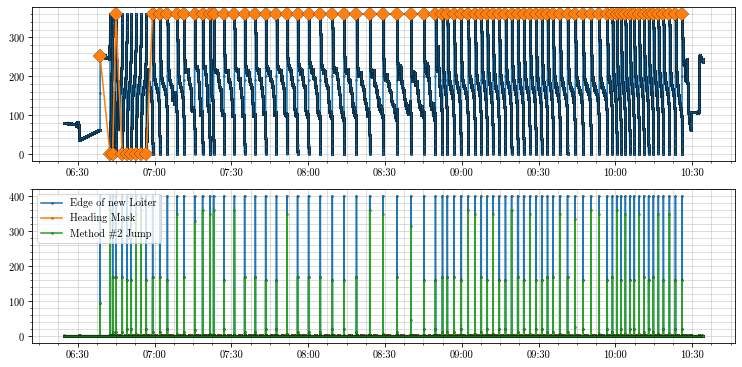

In [16]:
fig = plt.figure(figsize=(10,5), dpi=75)
ax1 = plt.subplot(2,1,1)
ax1.plot(df.index, df.Heading)
ax1.plot(df.index[edge_mask == True], df.Heading[edge_mask == True], marker='D', markersize=10, linestyle=None)

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(df.index, edge_mask*400, label='Edge of new Loiter')
ax2.plot(df.index, heading_mask, label="Heading Mask")
ax2.plot(df.index, jump, label="Method #2 Jump")
ax2.legend(loc='upper left')
plt.show()

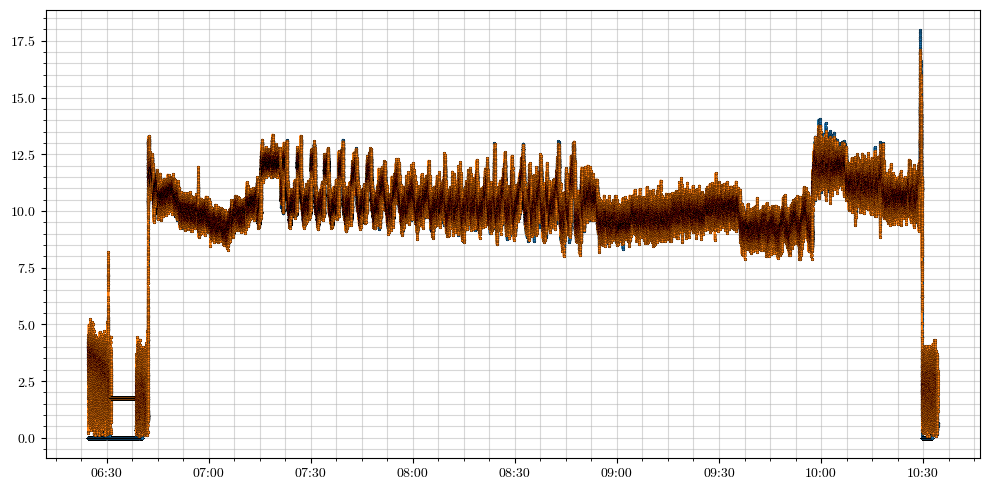

In [17]:
plt.figure(figsize=(10,5))
plt.plot(df.Airspeed_Sensor0)
plt.plot(df.Airspeed_Sensor1)
plt.show()

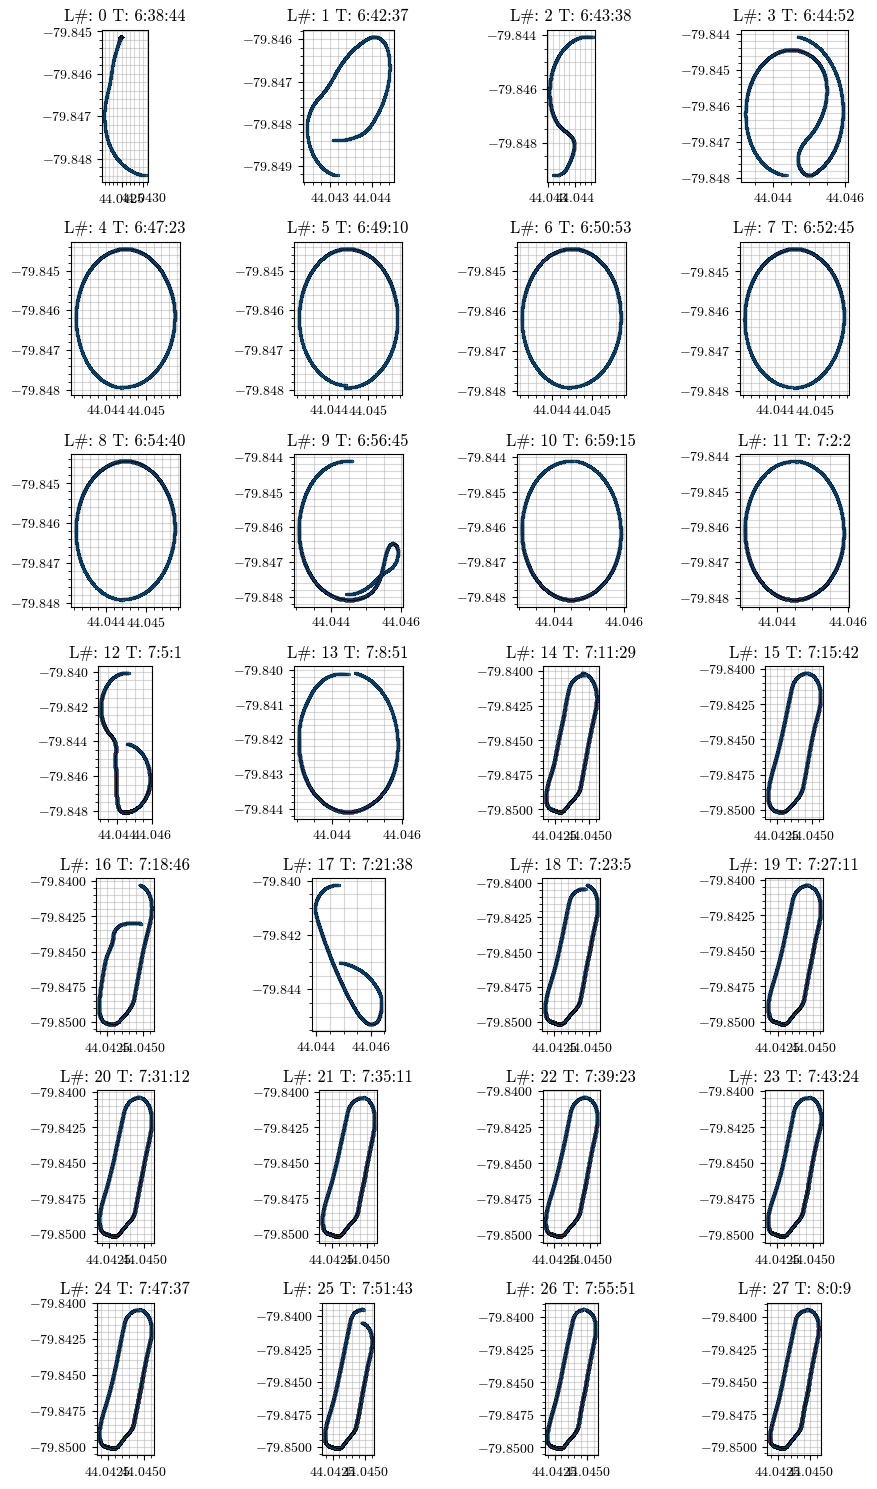

In [18]:
loiter_numbers = np.arange(0, 28) # Selecting the nth loiter of the flight for analysis #
show_loiters(loiter_numbers, df, loiter_times)

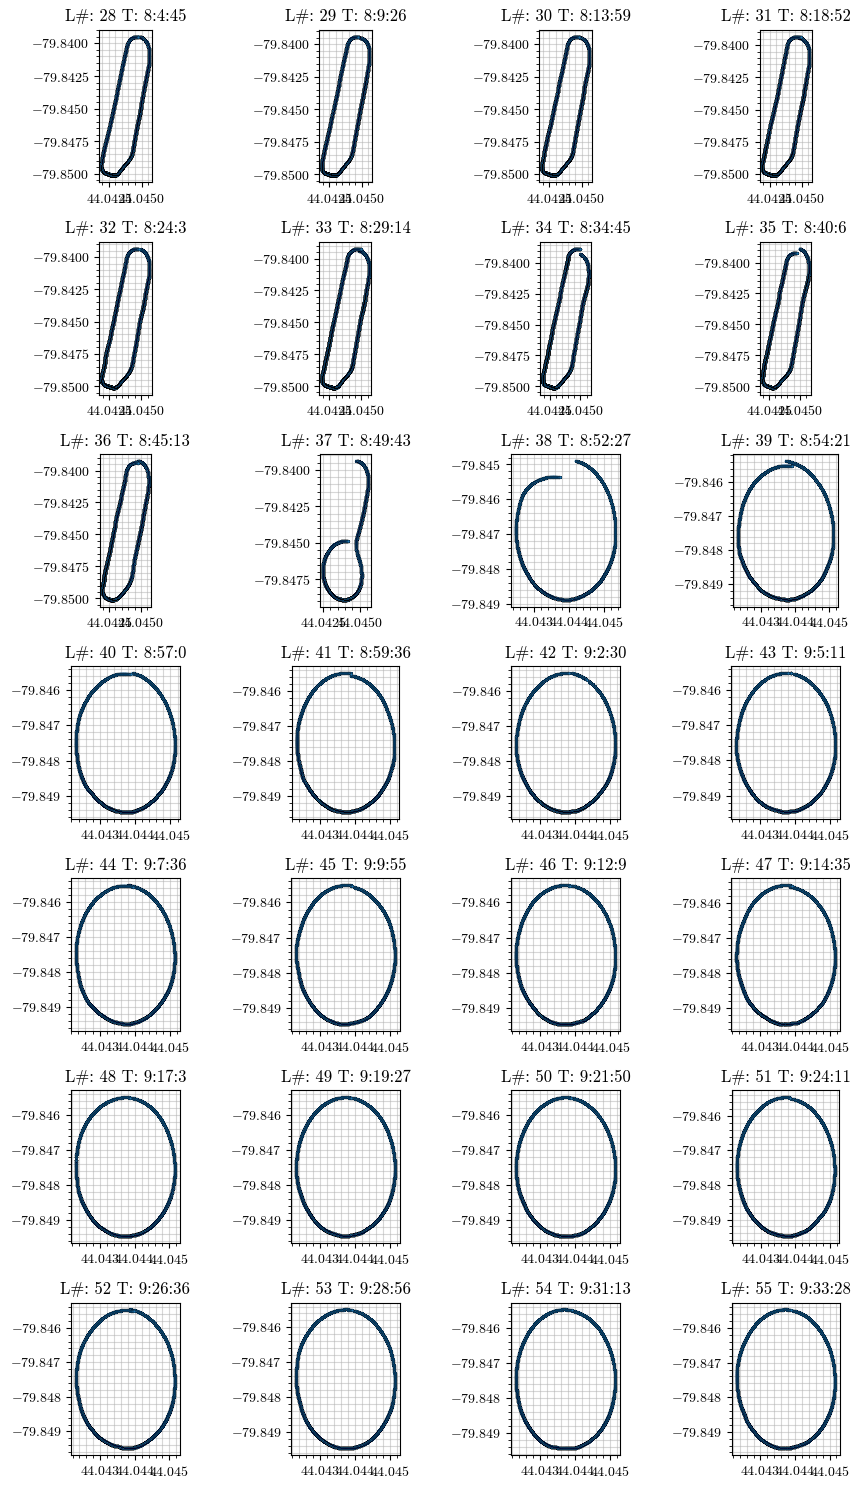

In [19]:
loiter_numbers = np.arange(28, 56) # Selecting the nth loiter of the flight for analysis #
show_loiters(loiter_numbers, df, loiter_times)

In [20]:
loiter_times.size

79

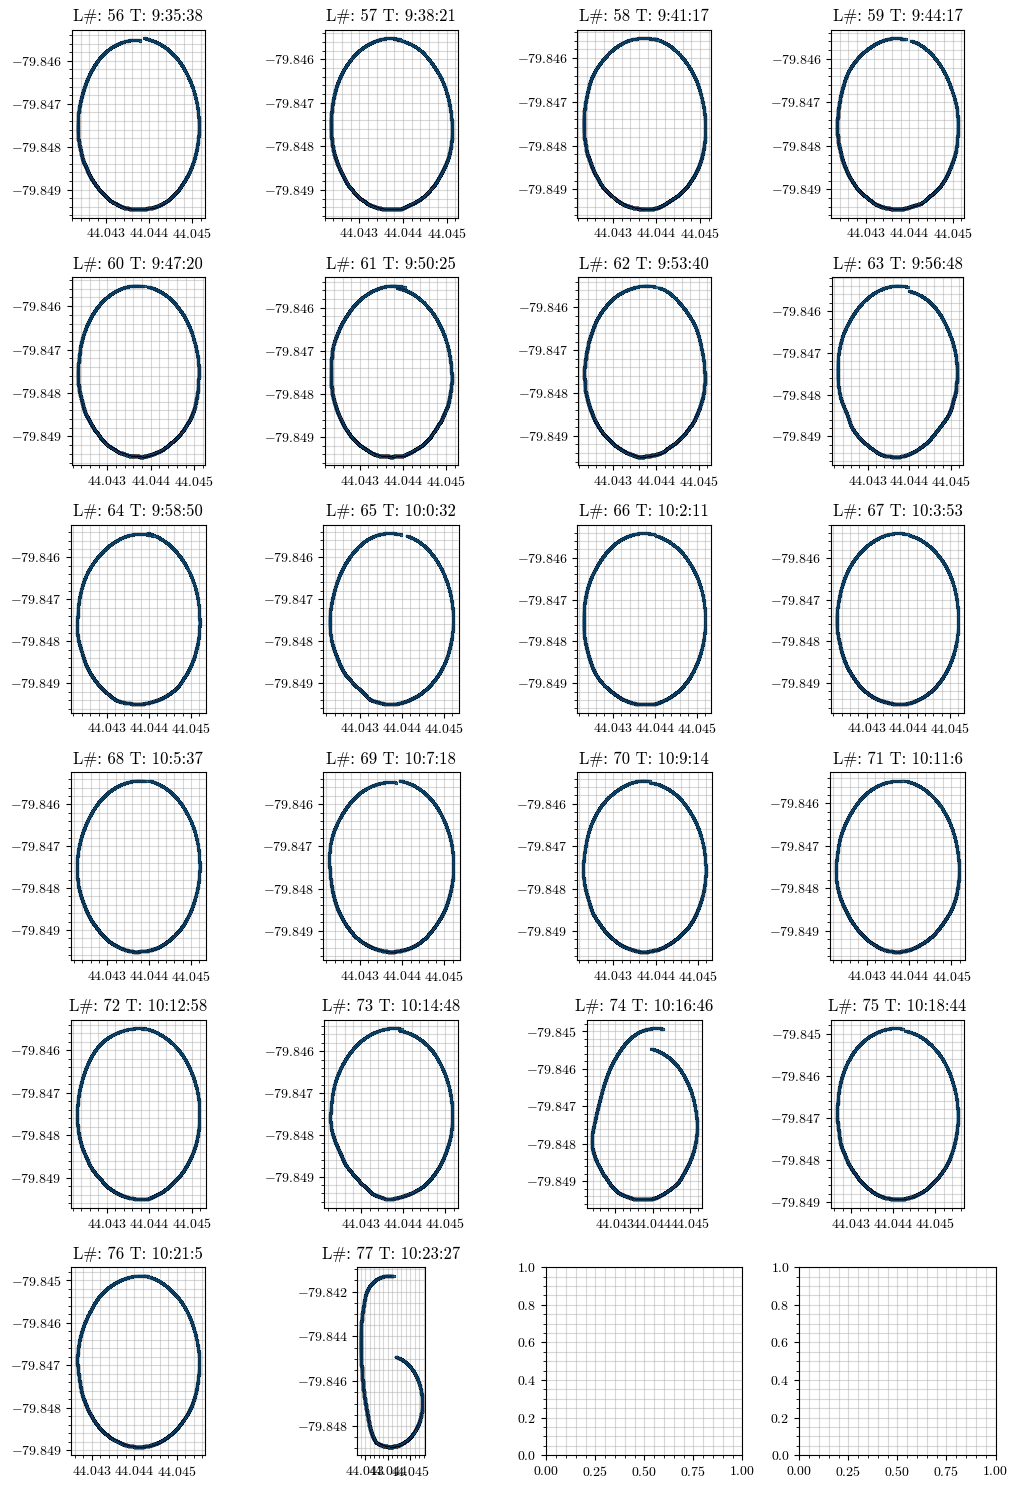

In [21]:
loiter_numbers = np.arange(56, 78) # Selecting the nth loiter of the flight for analysis #
show_loiters(loiter_numbers, df, loiter_times)

### Marking the Loiters that Are Circular
From viewing the liattitude longitude plots earlier.  

In [22]:
##
# 4-8
# 10-11, 13
# 39-55
# 56-73
# 75, 76

In [23]:
## Function for calculating the calibration point for a single run.  

def calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True):

    # Defining variables to grab from DF
    dynPressureName = "DynamicPressure_"+sensor
    rawPressureName = "RawPressure_"+sensor
    easVelocityName = "Airspeed_"+sensor 
    # Performing segmentation based on loiter selection
    [theta_complete, segments_complete] = collect_loiterdata(loiter_numbers, loiter_times, df)
    # Determining real airspeed based on fitted groundspeed data
    rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperature.to_numpy()+273.15))**-1
    Vg_actual = np.array(segments_complete.Groundspeed_GPS)
    [pop_result, cov_result] = optimize.curve_fit(wind_model, theta_complete, Vg_actual, [5, 10, 0])
    # Calculating mean dynamic pressure from sensor of interest
    q_sensor = 1 * np.abs(segments_complete[rawPressureName])
    q_measurement = np.mean(q_sensor)
    # print(q_measurement)
    # Printing Results of the fit
    residuals = Vg_actual - wind_model(theta_complete, *pop_result)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((Vg_actual - np.mean(Vg_actual))**2)
    r_square = 1 - (ss_res / ss_tot)
    # print(r_square)

    # Calculating airspeed ratio adjustment based on fitted EAS and measured EAS
    V_eas_fit = pop_result[1] * np.sqrt(np.mean(rho)/1.225)
    dP_fit = 0.5 * 1.225 * V_eas_fit**2 
    dP_sensor = np.mean(segments_complete[dynPressureName])

    SASR = 2.0 / 1.225
    ASR = SASR * (dP_fit / dP_sensor)   # This is the adjusted AS ratio to used, should be a function of the mean pressure measurement from the sensor being calibrated

    # Plotting fitted results   
    groundspeed_fit = wind_model(theta_complete, pop_result[0], pop_result[1], pop_result[2])
    if visualize:
        plt.figure(figsize=(10,5))
        plt.plot(theta_complete, segments_complete.Groundspeed_GPS, label="Ground Speed")
        plt.plot(theta_complete, segments_complete[easVelocityName], label="Sensor 0 Airspeed")
        plt.plot(theta_complete, groundspeed_fit, marker='', linestyle='--', color='orange', label="Fitted Ground Speed")
        plt.plot(theta_complete, np.ones(np.shape(theta_complete)) * pop_result[1], marker='', linestyle='--', color='black', label="Predicted Airspeed")
        plt.plot(theta_complete, np.ones(np.shape(theta_complete)) * np.mean(segments_complete[easVelocityName]), marker='', linestyle='-', label="Average Airspeed Sensor 0")

        plt.plot(theta_complete, segments_complete.Airspeed_Demanded, marker='', color='red', label="Demanded Airspeed")

        plt.legend(loc="upper right")
        plt.xlabel("Loiter Position (Degrees)")
        plt.ylabel("Speed [m/s]")
        plt.show()
    # Storing results into list of lists
    cal_points[0].append(q_measurement)
    cal_points[1].append(ASR)
    cal_points[2].append(r_square)
    return pop_result, ASR, q_measurement

## Getting Constant Demanded Airspeed Loiter Numbers

In [24]:
cal_points = [[], [], []]

### Airspeed Set #1


/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_38960/3395659828.py:12: RuntimeWarning: invalid value encountered in reciprocal
  rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperature.to_numpy()+273.15))**-1


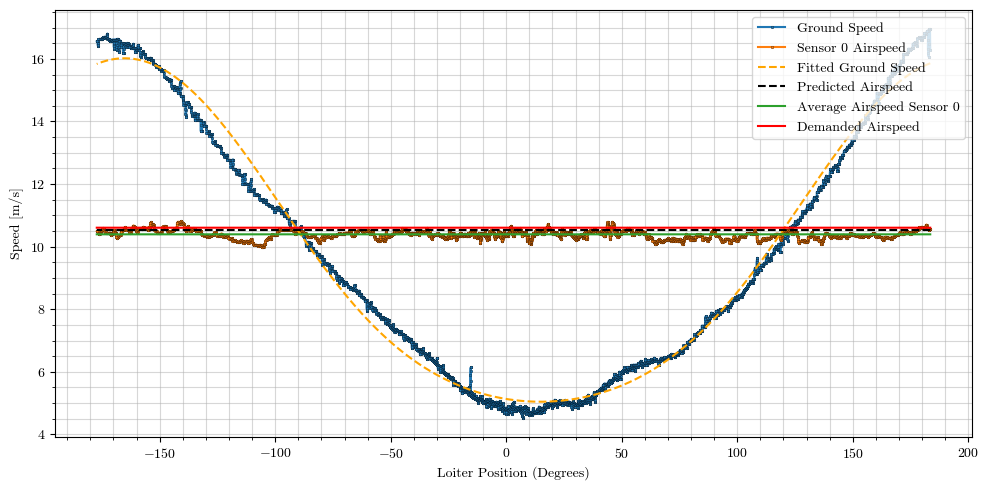

(array([ 5.48773768, 10.53199104, -1.8286275 ]),
 3.089535102129078,
 34.09664741105654)

In [25]:
loiter_numbers = np.arange(4, 5)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

### Airspeed Set #2

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_38960/3395659828.py:12: RuntimeWarning: invalid value encountered in reciprocal
  rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperature.to_numpy()+273.15))**-1


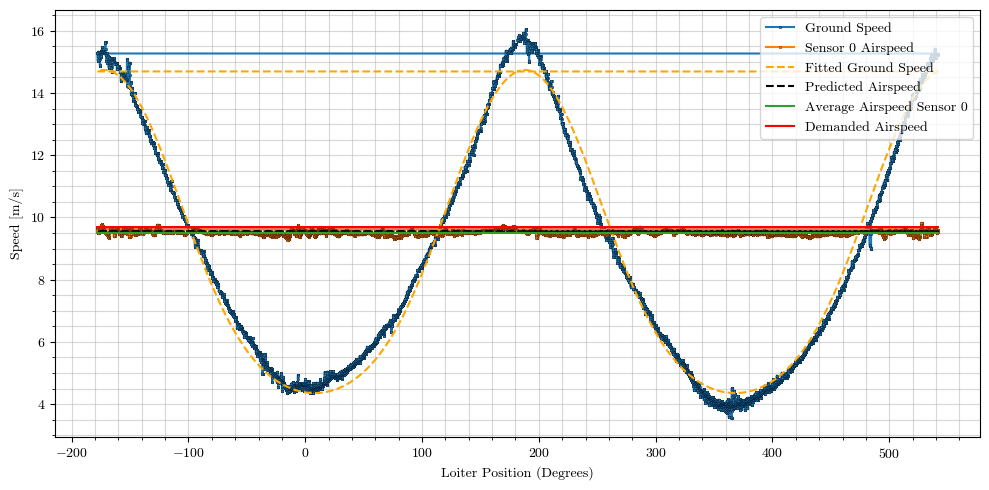

(array([ 5.19262424,  9.54684837, -1.71024586]),
 3.0337138068657215,
 28.50355089762264)

In [26]:
loiter_numbers = np.arange(7, 9)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

### Airspeed Set #3

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_38960/3395659828.py:12: RuntimeWarning: invalid value encountered in reciprocal
  rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperature.to_numpy()+273.15))**-1


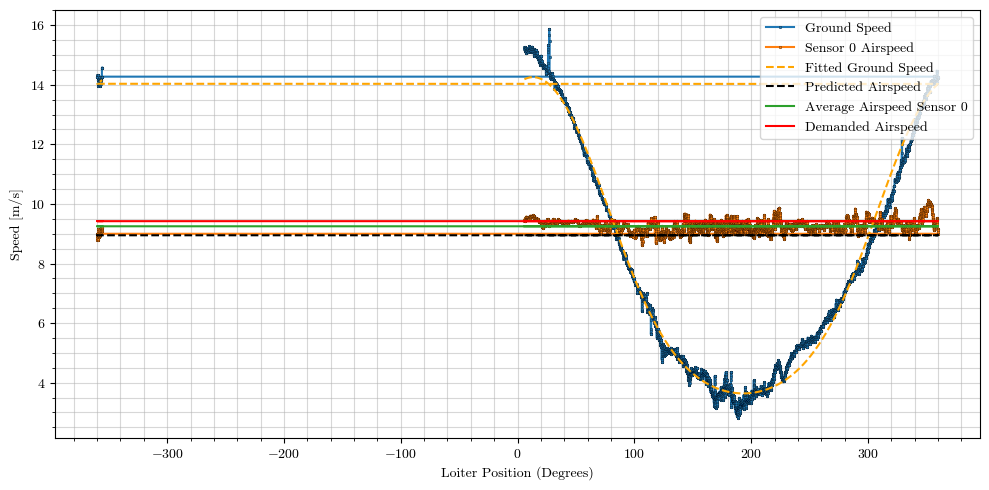

(array([5.31010076, 8.94773274, 1.33958748]),
 2.8143193349195017,
 27.03266010170282)

In [27]:
loiter_numbers = np.arange(40, 41)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

### Airspeed Set #4

In [28]:
loiter_numbers = np.arange(148, 151)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

IndexError: index 148 is out of bounds for axis 0 with size 79

### Airspeed Set #5

33.20236105074453
0.990795957297103


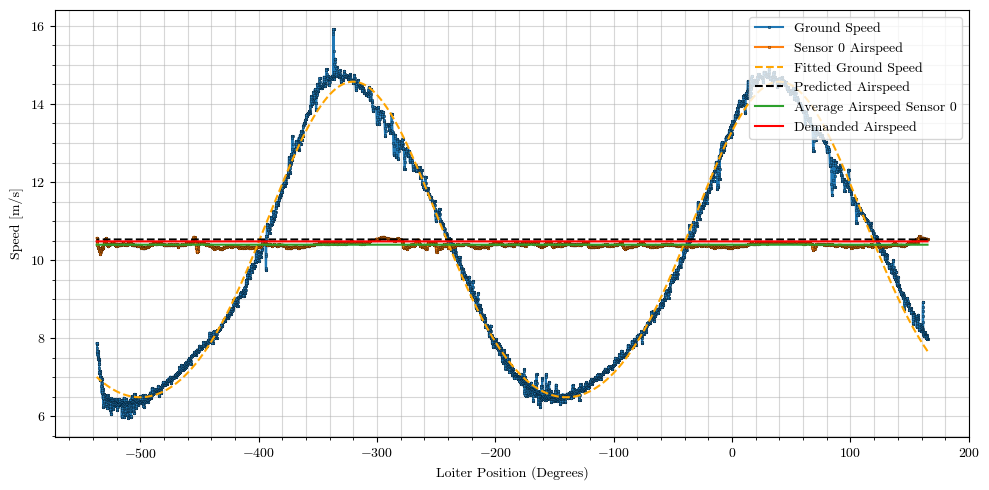

(array([ 4.04017815, 10.53041146,  0.8748963 ]),
 3.2193642834342286,
 33.20236105074453)

In [ ]:
loiter_numbers = np.arange(159, 161)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

### Airspeed Set #6

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_65475/3642858789.py:12: RuntimeWarning: invalid value encountered in reciprocal
  rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperature.to_numpy()+273.15))**-1


47.99408757074264
0.988116417935736


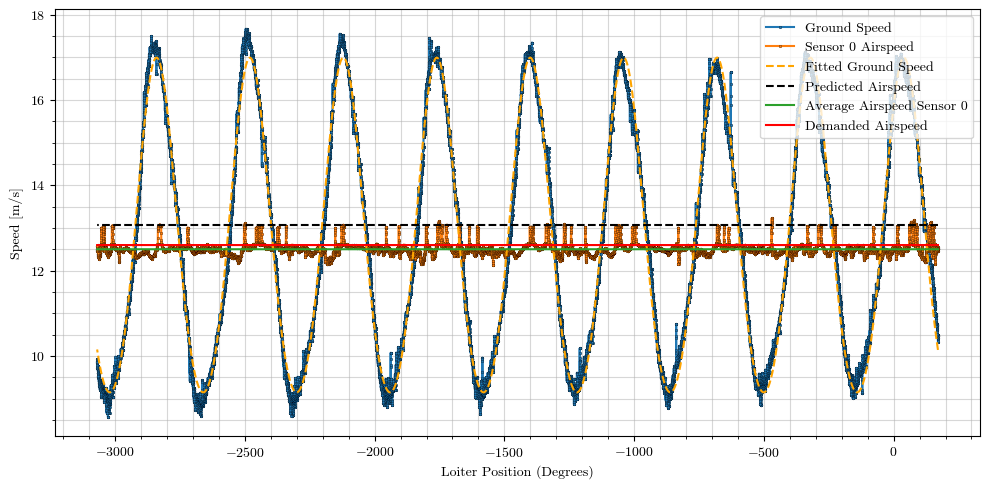

(array([ 3.9218797 , 13.06710411,  0.88128279]),
 3.436309917856017,
 47.99408757074264)

In [ ]:
loiter_numbers = np.arange(162, 171)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

### Airspeed Set #7

44.268620658171244
0.9868089612011586


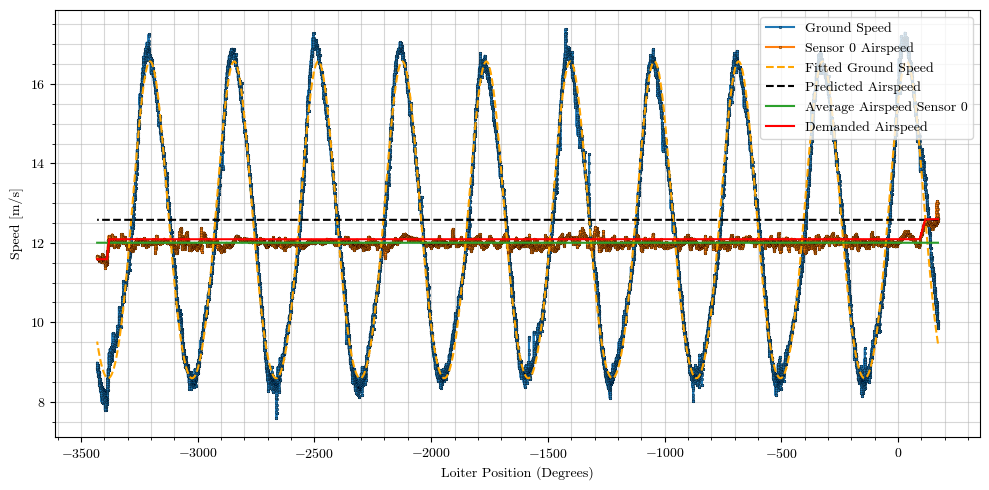

(array([ 3.98744237, 12.580441  ,  0.93831524]),
 3.4514052347368374,
 44.268620658171244)

In [ ]:
loiter_numbers = np.arange(171, 181)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

### Airspeed Set #8

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_65475/3642858789.py:12: RuntimeWarning: invalid value encountered in reciprocal
  rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperature.to_numpy()+273.15))**-1


40.55740630439423
0.9882020265148652


/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_65475/3642858789.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,5))


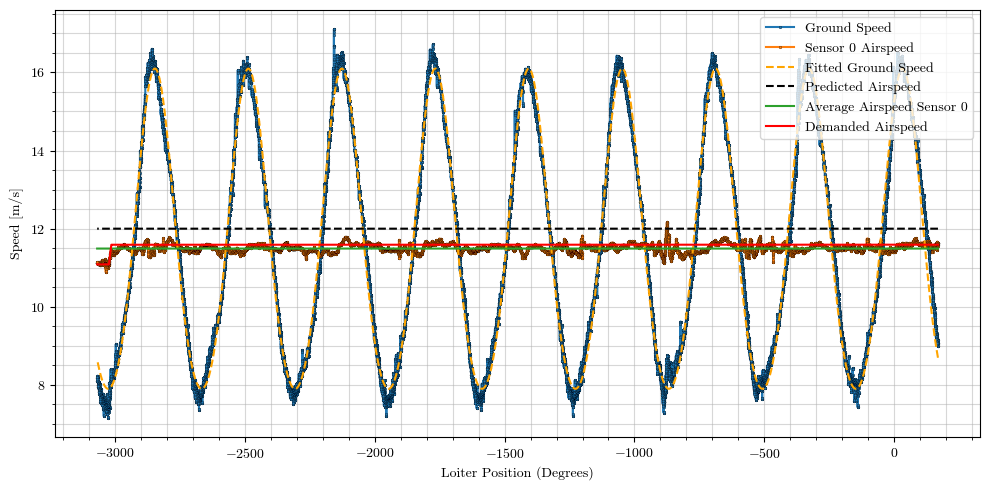

(array([ 4.10032445, 11.99917298,  0.99776284]),
 3.42551445898085,
 40.55740630439423)

In [ ]:
loiter_numbers = np.arange(181, 190)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

### Airspeed Set 

37.19706351685318
0.990329340335021


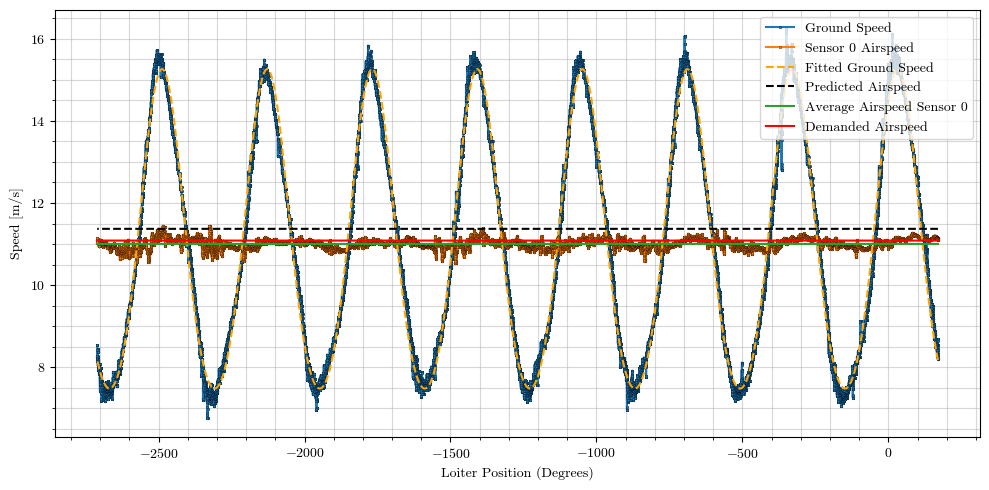

(array([ 3.88543936, 11.37098299,  1.01432866]),
 3.3513671656563626,
 37.19706351685318)

In [ ]:
loiter_numbers = np.arange(190, 198)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

### Airspeed Set

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_65475/3642858789.py:12: RuntimeWarning: invalid value encountered in reciprocal
  rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperature.to_numpy()+273.15))**-1


33.89718564031781
0.9873219242782625


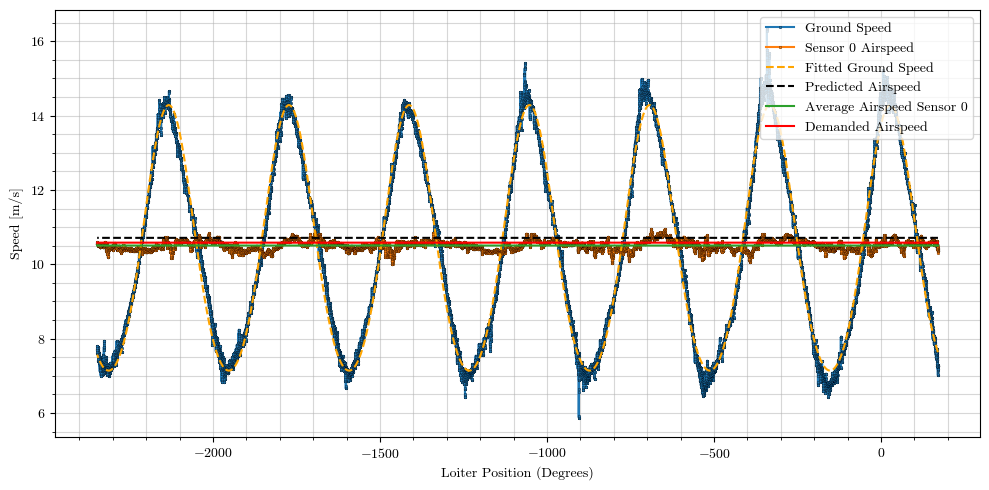

(array([ 3.57067853, 10.71066494,  1.09576335]),
 3.2610033159345093,
 33.89718564031781)

In [ ]:
loiter_numbers = np.arange(199, 206)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

### Airspeed Set

30.689908860216953
0.9764755961174784


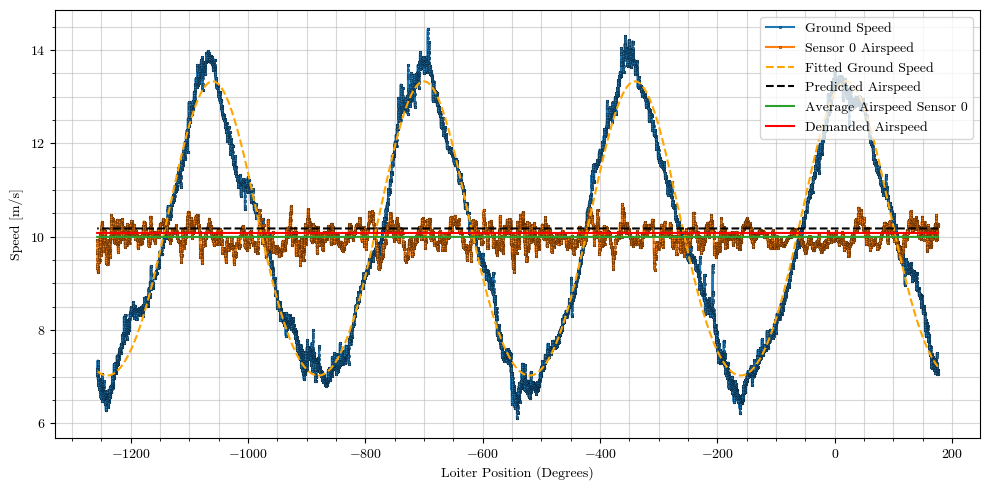

(array([ 3.15344952, 10.1744494 ,  1.22725425]),
 3.249400142047809,
 30.689908860216953)

In [ ]:
loiter_numbers = np.arange(207, 211)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_65475/3642858789.py:12: RuntimeWarning: invalid value encountered in reciprocal
  rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperature.to_numpy()+273.15))**-1


30.749845608738056
0.9718239929100898


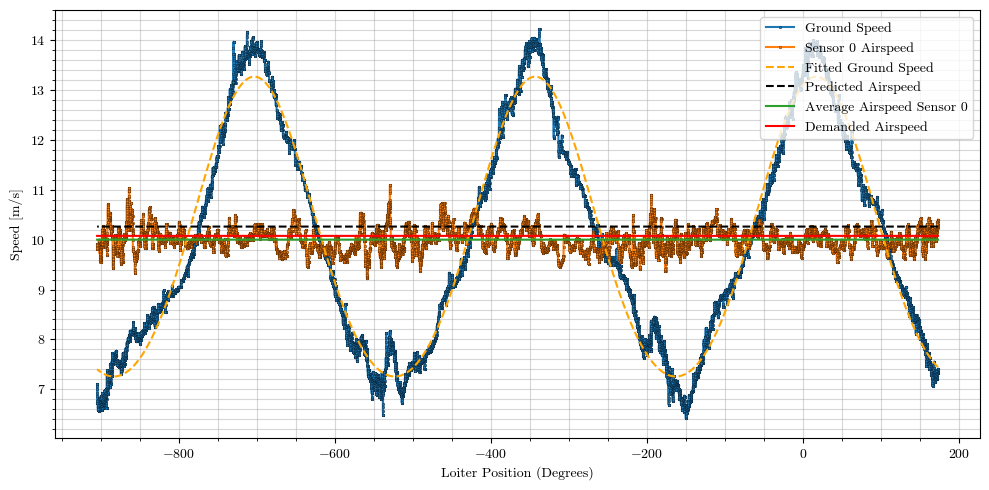

(array([ 3.00802249, 10.26419652,  1.27731784]),
 3.301798355252279,
 30.749845608738056)

In [ ]:
loiter_numbers = np.arange(213, 216)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

27.997377878372227
0.9590559014660466


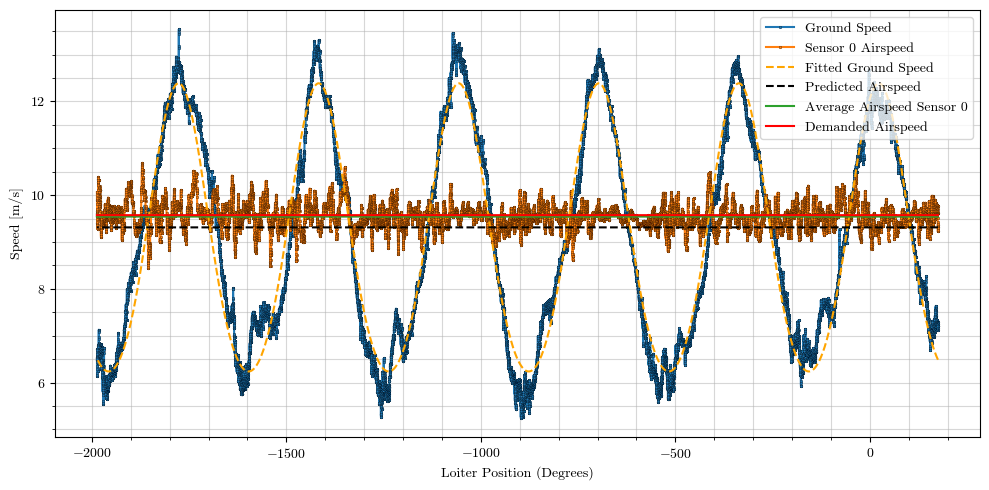

(array([3.07483683, 9.3130784 , 1.16889355]),
 2.9867273493176834,
 27.997377878372227)

In [ ]:
loiter_numbers = np.arange(217, 223)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

25.82225568402618
0.9548124644005143


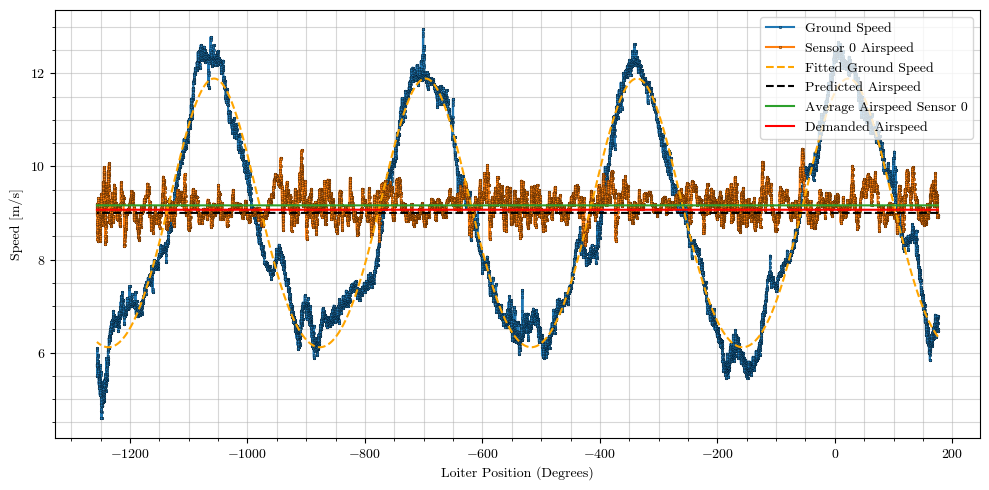

(array([2.88579918, 9.00245973, 1.1671134 ]),
 3.025517487288615,
 25.82225568402618)

In [ ]:
loiter_numbers = np.arange(224, 228)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_65475/3642858789.py:12: RuntimeWarning: invalid value encountered in reciprocal
  rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperature.to_numpy()+273.15))**-1


31.085592128980785
0.9484457524554978


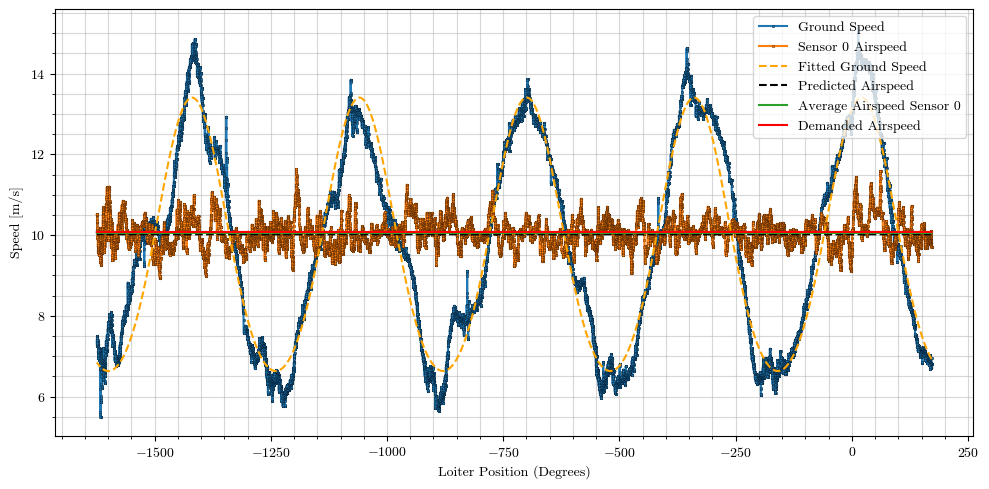

(array([ 3.38742891, 10.01918916,  1.2106777 ]),
 3.1097841011193643,
 31.085592128980785)

In [ ]:
loiter_numbers = np.arange(241, 246)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

33.8342881305375
0.8736732224633084


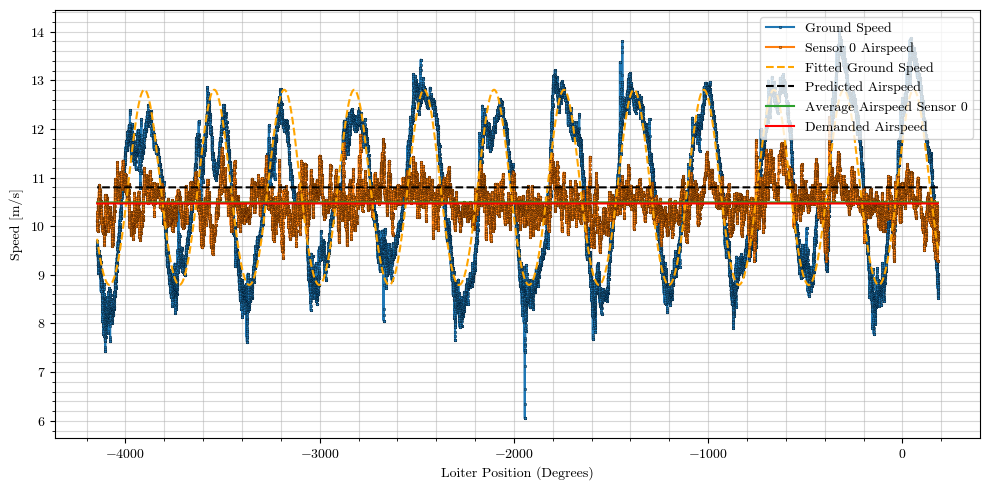

(array([ 2.00607624, 10.7990053 ,  0.56400228]),
 3.287997650863664,
 33.8342881305375)

In [ ]:
loiter_numbers = np.arange(274, 286)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

circular_loiters = [131-150, 159-160, 162-210, 213-228, 233, 236-238, 241-245, 248, 250-252, 258-259, 261, 274-285, 289-290, 301-303, 306-315, 318-322]

In [ ]:
# # Wind direction appears to have changed during this segment, excluding as result
# loiter_numbers = np.arange(306, 315)
# calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

In [ ]:
# Poor airspeed control
# loiter_numbers = np.arange(318, 323)
# calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor0", visualize=True)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_65475/1510597843.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='$R^2$')


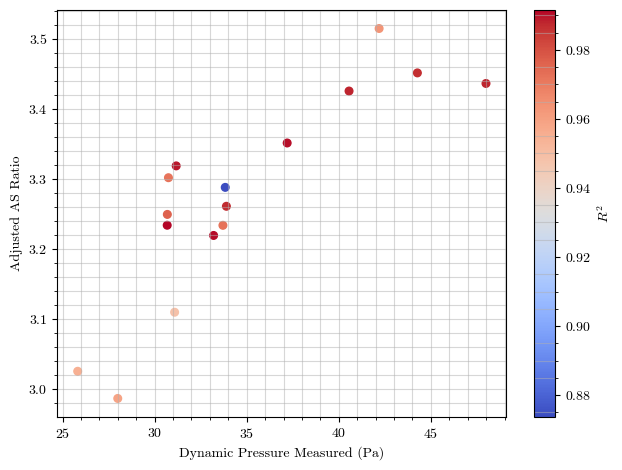

In [ ]:
plt.figure()
plt.scatter(cal_points[0], cal_points[1], c=cal_points[2], cmap='coolwarm', marker='o', s=30)
plt.xlabel("Dynamic Pressure Measured (Pa)")
plt.ylabel("Adjusted AS Ratio")
plt.colorbar(label='$R^2$')
plt.show()

## Creating Airspeed calibration Curve!

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_65475/3395659828.py:12: RuntimeWarning: invalid value encountered in reciprocal
  rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperature.to_numpy()+273.15))**-1
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_65475/3395659828.py:12: RuntimeWarning: invalid value encountered in reciprocal
  rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperature.to_numpy()+273.15))**-1
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_65475/3395659828.py:12: RuntimeWarning: invalid value encountered in reciprocal
  rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperature.to_numpy()+273.15))**-1
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_65475/3395659828.py:12: RuntimeWarning: invalid value encountered in reciprocal
  rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperat

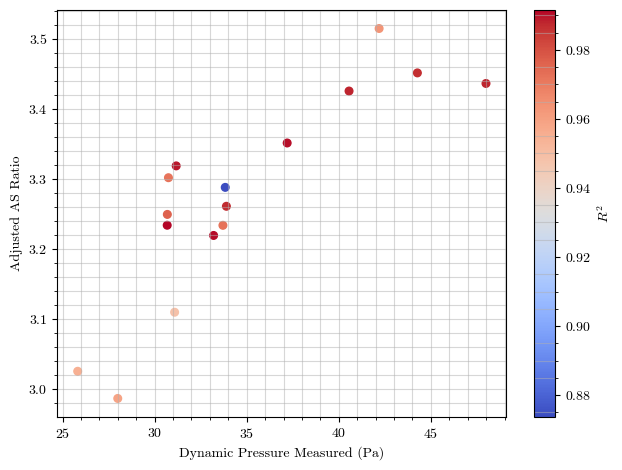

In [ ]:
cal_points = [[], [], []]
loiter_numbers = np.arange(133, 137)
calibration_point(loiter_numbers, loiter_times, df, cal_points, visualize=False)
loiter_numbers = np.arange(137, 139)
calibration_point(loiter_numbers, loiter_times, df, cal_points, visualize=False)
loiter_numbers = np.arange(139, 140)
calibration_point(loiter_numbers, loiter_times, df, cal_points, visualize=False)
loiter_numbers = np.arange(148, 151)
calibration_point(loiter_numbers, loiter_times, df, cal_points, visualize=False)
loiter_numbers = np.arange(159, 161)
calibration_point(loiter_numbers, loiter_times, df, cal_points, visualize=False)
loiter_numbers = np.arange(162, 171)
calibration_point(loiter_numbers, loiter_times, df, cal_points, visualize=False)
loiter_numbers = np.arange(171, 181)
calibration_point(loiter_numbers, loiter_times, df, cal_points, visualize=False)
loiter_numbers = np.arange(181, 190)
calibration_point(loiter_numbers, loiter_times, df, cal_points, visualize=False)
loiter_numbers = np.arange(190, 198)
calibration_point(loiter_numbers, loiter_times, df, cal_points, visualize=False)
loiter_numbers = np.arange(199, 206)
calibration_point(loiter_numbers, loiter_times, df, cal_points, visualize=False)
loiter_numbers = np.arange(207, 211)
calibration_point(loiter_numbers, loiter_times, df, cal_points, visualize=False)
loiter_numbers = np.arange(213, 216)
calibration_point(loiter_numbers, loiter_times, df, cal_points, visualize=False)
loiter_numbers = np.arange(217, 223)
calibration_point(loiter_numbers, loiter_times, df, cal_points, visualize=False)
loiter_numbers = np.arange(224, 228)
calibration_point(loiter_numbers, loiter_times, df, cal_points, visualize=False)
loiter_numbers = np.arange(241, 246)
calibration_point(loiter_numbers, loiter_times, df, cal_points, visualize=False)
loiter_numbers = np.arange(274, 286)
calibration_point(loiter_numbers, loiter_times, df, cal_points, visualize=False)

plt.figure()
plt.scatter(cal_points[0], cal_points[1], c=cal_points[2], cmap='coolwarm', marker='o', s=30)
plt.xlabel("Dynamic Pressure Measured (Pa)")
plt.ylabel("Adjusted AS Ratio")
plt.colorbar(label='$R^2$')
plt.show()

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_65475/3395659828.py:12: RuntimeWarning: invalid value encountered in reciprocal
  rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperature.to_numpy()+273.15))**-1
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_65475/3395659828.py:12: RuntimeWarning: invalid value encountered in reciprocal
  rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperature.to_numpy()+273.15))**-1
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_65475/3395659828.py:12: RuntimeWarning: invalid value encountered in reciprocal
  rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperature.to_numpy()+273.15))**-1
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_65475/3395659828.py:12: RuntimeWarning: invalid value encountered in reciprocal
  rho = segments_complete.Pressure.to_numpy() * (287 * (segments_complete.Ambient_Temperat

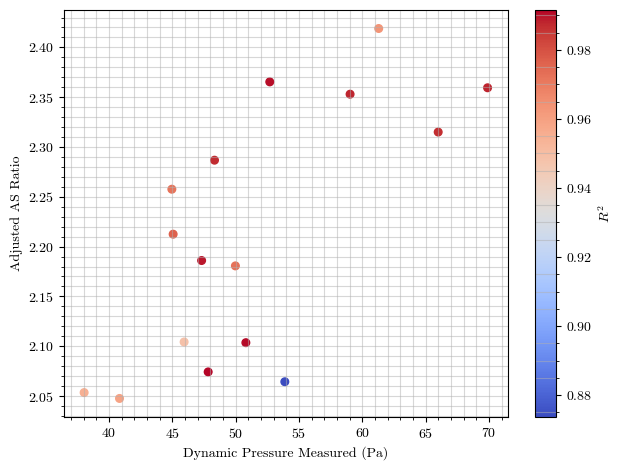

In [ ]:
cal_points = [[], [], []]
loiter_numbers = np.arange(133, 137)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor1", visualize=False)
loiter_numbers = np.arange(137, 139)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor1", visualize=False)
loiter_numbers = np.arange(139, 140)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor1", visualize=False)
loiter_numbers = np.arange(148, 151)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor1", visualize=False)
loiter_numbers = np.arange(159, 161)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor1", visualize=False)
loiter_numbers = np.arange(162, 171)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor1", visualize=False)
loiter_numbers = np.arange(171, 181)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor1", visualize=False)
loiter_numbers = np.arange(181, 190)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor1", visualize=False)
loiter_numbers = np.arange(190, 198)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor1", visualize=False)
loiter_numbers = np.arange(199, 206)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor1", visualize=False)
loiter_numbers = np.arange(207, 211)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor1", visualize=False)
loiter_numbers = np.arange(213, 216)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor1", visualize=False)
loiter_numbers = np.arange(217, 223)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor1", visualize=False)
loiter_numbers = np.arange(224, 228)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor1", visualize=False)
loiter_numbers = np.arange(241, 246)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor1", visualize=False)
loiter_numbers = np.arange(274, 286)
calibration_point(loiter_numbers, loiter_times, df, cal_points, sensor="Sensor1", visualize=False)

plt.figure()
plt.scatter(cal_points[0], cal_points[1], c=cal_points[2], cmap='coolwarm', marker='o', s=30)
plt.xlabel("Dynamic Pressure Measured (Pa)")
plt.ylabel("Adjusted AS Ratio")
plt.colorbar(label='$R^2$')
plt.show()

In [ ]:
mask_array = times2maskarray(df, loiter_times)